In [1]:
import os as os
import json as json
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import colorConverter
import seaborn as sns

%matplotlib inline

In [2]:
import parmed as pmd
import pytraj as pt

import logging
import datetime as dt
d_date = dt.datetime.now()
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%Y-%m-%d %I:%M:%S %p',
                    level=logging.DEBUG)
logging.info('Started logging...')

import paprika
print(paprika.__version__)

from paprika.restraints import static_DAT_restraint
from paprika.restraints import DAT_restraint
from paprika.restraints import amber_restraint_line
from paprika.restraints import create_window_list

from paprika.utils import make_window_dirs

from paprika.analysis import fe_calc

2018-06-07 12:51:22 PM Started logging...
2018-06-07 12:51:22 PM OpenMM support: Yes


2018-06-07_12:50:28_-0700-bb2ce47-0.0.3


In [3]:
prefix = '/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/'

In [4]:
hg = pmd.load_file('systems/a-bam-p/confirm-original/a000/full.hmr.topo',
                   'systems/a-bam-p/confirm-original/a000/full.crds',
                    structure=True)

dummy_anchors = [':1', ':2', ':3']
host_anchors  = [':4@O3', ':6@C1', ':8@C6']
guest_anchors = [':10@C4', ':10@N1']

In [5]:
attach_string = '0.00 0.40 0.80 1.60 2.40 4.00 5.50 8.65 11.80 18.10 24.40 37.00 49.60 74.80 100.00'
attach_fractions = [float(i) / 100 for i in attach_string.split()]

pull_string = '0.00 0.40 0.80 1.20 1.60 2.00 2.40 2.80 3.20 3.60 4.00 4.40 4.80 5.20 5.60 6.00 6.40 6.80 7.20 7.60 8.00 8.40 8.80 9.20 9.60 10.00 10.40 10.80 11.20 11.60 12.00 12.40 12.80 13.20 13.60 14.00 14.40 14.80 15.20 15.60 16.00 16.40 16.80 17.20 17.60 18.00'
pull_distances = [float(i) + 6.00 for i in pull_string.split()]

release_fractions = attach_fractions[::-1]

windows = [len(attach_fractions), len(pull_distances), len(release_fractions)]
print(f'There are {windows} windows in this attach-pull-release calculation.')

There are [15, 46, 15] windows in this attach-pull-release calculation.


In [6]:
static_restraint_atoms = [[dummy_anchors[0], host_anchors[0]],
                          [dummy_anchors[1], dummy_anchors[0], host_anchors[0]],
                          [dummy_anchors[2], dummy_anchors[1], dummy_anchors[0], host_anchors[0]],
                          [dummy_anchors[0], host_anchors[0], host_anchors[1]],
                          [dummy_anchors[1], dummy_anchors[0], host_anchors[0], host_anchors[1]],
                          [dummy_anchors[0], host_anchors[0], host_anchors[1], host_anchors[2]],
                        ]

static_restraint_distance_fc = 5.0
static_restraint_angle_fc = 100.0

In [7]:
guest_restraint_atoms = [[dummy_anchors[0], guest_anchors[0]],
                         [dummy_anchors[1], dummy_anchors[0], guest_anchors[0]],
                         [dummy_anchors[0], guest_anchors[0], guest_anchors[1]],
                        ]

guest_restraint_targets = [6.0,
                           180.0,
                           180.0
                          ]
guest_restraint_target_final = [24.0, 180.0, 180.0]
guest_restraint_distance_fc = 5.0
guest_restraint_angle_fc = 100.0

In [8]:
host_conformational_template = [['O5', 'C1', 'O1', 'C4'],
                                ['C1', 'O1', 'C4', 'C5']
                               ]

host_residues = len(hg[':MGO'].residues)
first_host_residue = hg[':MGO'].residues[0].number + 1
conformational_restraint_atoms = []
conformational_restraint_targets = []
conformational_restraint_fc = 6.0

for n in range(first_host_residue, host_residues + first_host_residue):
    if n + 1 < host_residues + first_host_residue:
        next_residue = n + 1
    else:
        next_residue = first_host_residue
    conformational_restraint_atoms.append(
        [f':{n}@{host_conformational_template[0][0]}',
         f':{n}@{host_conformational_template[0][1]}',
         f':{n}@{host_conformational_template[0][2]}',
         f':{next_residue}@{host_conformational_template[0][3]}'
        ])
    conformational_restraint_targets.append(104.30)
    conformational_restraint_atoms.append(
        [f':{n}@{host_conformational_template[1][0]}',
         f':{n}@{host_conformational_template[1][1]}',
         f':{next_residue}@{host_conformational_template[1][2]}',
         f':{next_residue}@{host_conformational_template[1][3]}'
        ])
    conformational_restraint_targets.append(-108.8)

In [9]:
guest_wall_template = [
    ['O2', guest_anchors[0]],
    ['O6', guest_anchors[0]]
]

guest_wall_restraint_atoms = []
guest_wall_restraint_targets = []
guest_wall_restraint_angle_fc = 500.0
guest_wall_restraint_distance_fc = 50.0

for n in range(first_host_residue, host_residues + first_host_residue):
    guest_wall_restraint_atoms.append(
        [f':{n}@{guest_wall_template[0][0]}',
         f'{guest_wall_template[0][1]}',
        ])
    guest_wall_restraint_targets.append(11.3)
    guest_wall_restraint_atoms.append(
        [f':{n}@{guest_wall_template[1][0]}',
         f'{guest_wall_template[1][1]}',
        ])
    guest_wall_restraint_targets.append(13.3)

guest_wall_restraint_atoms.append([dummy_anchors[1],
                                 guest_anchors[0],
                                 guest_anchors[1]])
guest_wall_restraint_targets.append(80.0)

In [10]:
static_restraints = []
for index, atoms in enumerate(static_restraint_atoms):    
    this = static_DAT_restraint(restraint_mask_list=atoms,
                        num_window_list=windows, 
                        ref_structure=hg,
                        force_constant=static_restraint_angle_fc if len(atoms) > 2 else static_restraint_distance_fc,
                        amber_index=True)
    static_restraints.append(this)

2018-06-07 12:51:23 PM Calculating attach targets and force constants...
2018-06-07 12:51:23 PM Attach, Method #1
2018-06-07 12:51:23 PM Calculating pull targets and force constants...
2018-06-07 12:51:23 PM Pull, Method #1
2018-06-07 12:51:23 PM Calculating release targets and force constants...
2018-06-07 12:51:23 PM Release, Method #1
2018-06-07 12:51:23 PM Number of attach windows = 15
2018-06-07 12:51:23 PM Number of pull windows = 46
2018-06-07 12:51:23 PM Number of release windows = 15
2018-06-07 12:51:23 PM Assigning atom indices...
2018-06-07 12:51:23 PM There are 1 atoms in the mask :1  ...
2018-06-07 12:51:23 PM There are 1 atoms in the mask :4@O3  ...
2018-06-07 12:51:24 PM Calculating attach targets and force constants...
2018-06-07 12:51:24 PM Attach, Method #1
2018-06-07 12:51:24 PM Calculating pull targets and force constants...
2018-06-07 12:51:24 PM Pull, Method #1
2018-06-07 12:51:24 PM Calculating release targets and force constants...
2018-06-07 12:51:24 PM Release

In [11]:
guest_restraints = []
for index, atoms in enumerate(guest_restraint_atoms): 
    if len(atoms) > 2:
        angle = True
    else:
        angle = False
    this = DAT_restraint()
    this.auto_apr = True
    this.amber_index = True
    this.topology = hg
    this.mask1 = atoms[0]
    this.mask2 = atoms[1]
    if angle:
        this.mask3 = atoms[2]
        this.attach['fc_final'] = guest_restraint_angle_fc
        this.release['fc_final'] = guest_restraint_angle_fc
    else:
        this.attach['fc_final'] = guest_restraint_distance_fc
        this.release['fc_final'] = guest_restraint_distance_fc
    this.attach['target'] = guest_restraint_targets[index]
    this.attach['fraction_list'] = attach_fractions
    
    this.pull['target_final'] = guest_restraint_target_final[index]
    this.pull['num_windows'] = windows[1]
    
    this.release['target'] = guest_restraint_targets[index]
    # Keep the guest restraints on during release.
    this.release['fraction_list'] = [1.0] * windows[2]
    
    this.initialize()
    guest_restraints.append(this)

2018-06-07 12:51:26 PM Calculating attach targets and force constants...
2018-06-07 12:51:26 PM Attach, Method #3
2018-06-07 12:51:26 PM Calculating pull targets and force constants...
2018-06-07 12:51:26 PM Pull, Method #1
2018-06-07 12:51:26 PM Calculating release targets and force constants...
2018-06-07 12:51:26 PM Release, Method #3
2018-06-07 12:51:26 PM Number of attach windows = 15
2018-06-07 12:51:26 PM Number of pull windows = 46
2018-06-07 12:51:26 PM Number of release windows = 15
2018-06-07 12:51:26 PM Assigning atom indices...
2018-06-07 12:51:26 PM There are 1 atoms in the mask :1  ...
2018-06-07 12:51:26 PM There are 1 atoms in the mask :10@C4  ...
2018-06-07 12:51:26 PM Calculating attach targets and force constants...
2018-06-07 12:51:26 PM Attach, Method #3
2018-06-07 12:51:26 PM Calculating pull targets and force constants...
2018-06-07 12:51:26 PM Pull, Method #1
2018-06-07 12:51:26 PM Calculating release targets and force constants...
2018-06-07 12:51:26 PM Releas

In [12]:
conformational_restraints = []
for index, atoms in enumerate(conformational_restraint_atoms): 
    
    this = DAT_restraint()
    this.auto_apr = True
    this.amber_index = True
    this.topology = hg
    this.mask1 = atoms[0]
    this.mask2 = atoms[1]
    this.mask3 = atoms[2]
    this.mask4 = atoms[3]
    
    this.attach['fraction_list'] = attach_fractions
    this.attach['target'] = conformational_restraint_targets[index]
    this.attach['fc_final'] = conformational_restraint_fc
    this.pull['target_final'] = conformational_restraint_targets[index]
    this.pull['num_windows'] = windows[1]
    
    this.release['fraction_list'] = release_fractions
    this.release['target'] = conformational_restraint_targets[index]
    this.release['fc_final'] = conformational_restraint_fc
    
    this.initialize()
    conformational_restraints.append(this)

2018-06-07 12:51:26 PM Calculating attach targets and force constants...
2018-06-07 12:51:26 PM Attach, Method #3
2018-06-07 12:51:26 PM Calculating pull targets and force constants...
2018-06-07 12:51:26 PM Pull, Method #1
2018-06-07 12:51:26 PM Calculating release targets and force constants...
2018-06-07 12:51:26 PM Release, Method #3
2018-06-07 12:51:26 PM Number of attach windows = 15
2018-06-07 12:51:26 PM Number of pull windows = 46
2018-06-07 12:51:26 PM Number of release windows = 15
2018-06-07 12:51:26 PM Assigning atom indices...
2018-06-07 12:51:26 PM There are 1 atoms in the mask :4@O5  ...
2018-06-07 12:51:26 PM There are 1 atoms in the mask :4@C1  ...
2018-06-07 12:51:27 PM There are 1 atoms in the mask :4@O1  ...
2018-06-07 12:51:27 PM There are 1 atoms in the mask :5@C4  ...
2018-06-07 12:51:27 PM Calculating attach targets and force constants...
2018-06-07 12:51:27 PM Attach, Method #3
2018-06-07 12:51:27 PM Calculating pull targets and force constants...
2018-06-07 1

2018-06-07 12:51:29 PM Pull, Method #1
2018-06-07 12:51:29 PM Calculating release targets and force constants...
2018-06-07 12:51:29 PM Release, Method #3
2018-06-07 12:51:29 PM Number of attach windows = 15
2018-06-07 12:51:29 PM Number of pull windows = 46
2018-06-07 12:51:29 PM Number of release windows = 15
2018-06-07 12:51:29 PM Assigning atom indices...
2018-06-07 12:51:29 PM There are 1 atoms in the mask :9@O5  ...
2018-06-07 12:51:29 PM There are 1 atoms in the mask :9@C1  ...
2018-06-07 12:51:29 PM There are 1 atoms in the mask :9@O1  ...
2018-06-07 12:51:29 PM There are 1 atoms in the mask :4@C4  ...
2018-06-07 12:51:29 PM Calculating attach targets and force constants...
2018-06-07 12:51:29 PM Attach, Method #3
2018-06-07 12:51:29 PM Calculating pull targets and force constants...
2018-06-07 12:51:29 PM Pull, Method #1
2018-06-07 12:51:29 PM Calculating release targets and force constants...
2018-06-07 12:51:29 PM Release, Method #3
2018-06-07 12:51:29 PM Number of attach wi

In [13]:
wall_restraints = []
for index, atoms in enumerate(guest_wall_restraint_atoms): 
    if len(atoms) > 2:
        angle = True
    else:
        angle = False
    
    this = DAT_restraint()
    this.auto_apr = True
    this.amber_index = True
    this.topology = hg
    this.mask1 = atoms[0]
    this.mask2 = atoms[1]
    if angle:
        this.mask3 = atoms[2]
        this.attach['fc_initial'] = guest_wall_restraint_angle_fc
        this.attach['fc_final'] = guest_wall_restraint_angle_fc
        this.custom_restraint_values['rk2'] = 500.0
        this.custom_restraint_values['rk3'] = 0.0
    else:
        this.attach['fc_initial'] = guest_wall_restraint_distance_fc
        this.attach['fc_final'] = guest_wall_restraint_distance_fc
        this.custom_restraint_values['rk2'] = 50.0
        this.custom_restraint_values['rk3'] = 50.0
        this.custom_restraint_values['r1'] = 0.0
        this.custom_restraint_values['r2'] = 0.0

    this.attach['target'] = guest_wall_restraint_targets[index]
    this.attach['num_windows'] = len(attach_fractions)
       
    this.initialize()
    wall_restraints.append(this)

2018-06-07 12:51:29 PM Calculating attach targets and force constants...
2018-06-07 12:51:29 PM Attach, Method #1
2018-06-07 12:51:29 PM Calculating pull targets and force constants...
2018-06-07 12:51:29 PM No restraint info set for the pull phase! Skipping...
2018-06-07 12:51:29 PM Calculating release targets and force constants...
2018-06-07 12:51:29 PM No restraint info set for the release phase! Skipping...
2018-06-07 12:51:29 PM Number of attach windows = 15
2018-06-07 12:51:29 PM This restraint will be skipped in the pull phase
2018-06-07 12:51:29 PM This restraint will be skipped in the release phase
2018-06-07 12:51:29 PM Assigning atom indices...
2018-06-07 12:51:29 PM There are 1 atoms in the mask :4@O2  ...
2018-06-07 12:51:29 PM There are 1 atoms in the mask :10@C4  ...
2018-06-07 12:51:29 PM Calculating attach targets and force constants...
2018-06-07 12:51:29 PM Attach, Method #1
2018-06-07 12:51:29 PM Calculating pull targets and force constants...
2018-06-07 12:51:29 P

2018-06-07 12:51:30 PM Calculating release targets and force constants...
2018-06-07 12:51:30 PM No restraint info set for the release phase! Skipping...
2018-06-07 12:51:30 PM Number of attach windows = 15
2018-06-07 12:51:30 PM This restraint will be skipped in the pull phase
2018-06-07 12:51:30 PM This restraint will be skipped in the release phase
2018-06-07 12:51:30 PM Assigning atom indices...
2018-06-07 12:51:30 PM There are 1 atoms in the mask :9@O2  ...
2018-06-07 12:51:30 PM There are 1 atoms in the mask :10@C4  ...
2018-06-07 12:51:30 PM Calculating attach targets and force constants...
2018-06-07 12:51:30 PM Attach, Method #1
2018-06-07 12:51:30 PM Calculating pull targets and force constants...
2018-06-07 12:51:30 PM No restraint info set for the pull phase! Skipping...
2018-06-07 12:51:30 PM Calculating release targets and force constants...
2018-06-07 12:51:30 PM No restraint info set for the release phase! Skipping...
2018-06-07 12:51:30 PM Number of attach windows = 15

In [14]:
window_list = create_window_list(guest_restraints)

2018-06-07 12:51:31 PM All restraints are "continuous_apr" style.
2018-06-07 12:51:31 PM Restraints appear to be consistent


In [15]:
structure = pt.load(
    os.path.join('systems', 'a-bam-p', 'confirm-original', 'a000', 'full.crds'),
    os.path.join('systems', 'a-bam-p', 'confirm-original', 'a000', 'full.hmr.topo'))

stripped = structure.strip(':WAT,:Na+,:Cl-')

In [16]:
analyze = fe_calc()
analyze.prmtop = stripped.topology
analyze.trajectory = 'prod.000.nc'
analyze.path = os.path.join('/home', 'dslochower', 'kirkwood', 'projects', 'smirnoff-host-guest-simulations', 
                            'systems', 'a-bam-p', 'confirm-original')


In [17]:
analyze.restraint_list = guest_restraints + conformational_restraints
analyze.collect_data()
analyze.methods = ['ti-block']

analyze.compute_largest_neighbor = False
analyze.ti_matrix = 'endpoints'
analyze.compute_roi = True

analyze.quicker_ti_matrix = True
analyze.bootcycles = 1000
analyze.compute_free_energy()
analyze.compute_ref_state_work([guest_restraints[0], guest_restraints[1], None, None, guest_restraints[2], None])

2018-06-07 12:51:31 PM Replacing /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/confirm-original/a014 with /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/confirm-original/p000 in ['/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/confirm-original/a000', '/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/confirm-original/a001', '/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/confirm-original/a002', '/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/confirm-original/a003', '/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/confirm-original/a004', '/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/confirm-original/a005', '/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/confirm-original

2018-06-07 12:51:36 PM Loaded 5000 frames...
2018-06-07 12:51:36 PM Load trajectories from /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/confirm-original/p008...
2018-06-07 12:51:36 PM Loaded 5000 frames...
2018-06-07 12:51:36 PM Load trajectories from /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/confirm-original/p009...
2018-06-07 12:51:36 PM Loaded 5000 frames...
2018-06-07 12:51:36 PM Load trajectories from /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/confirm-original/p010...
2018-06-07 12:51:36 PM Loaded 5000 frames...
2018-06-07 12:51:36 PM Load trajectories from /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/confirm-original/p011...
2018-06-07 12:51:36 PM Loaded 5000 frames...
2018-06-07 12:51:36 PM Load trajectories from /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/confirm-original/p012...
2018-

2018-06-07 12:51:38 PM Load trajectories from /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/confirm-original/r011...
2018-06-07 12:51:38 PM Loaded 5000 frames...
2018-06-07 12:51:38 PM Load trajectories from /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/confirm-original/r010...
2018-06-07 12:51:38 PM Loaded 5000 frames...
2018-06-07 12:51:39 PM Load trajectories from /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/confirm-original/r009...
2018-06-07 12:51:39 PM Loaded 5000 frames...
2018-06-07 12:51:39 PM Load trajectories from /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/confirm-original/r008...
2018-06-07 12:51:39 PM Loaded 5000 frames...
2018-06-07 12:51:39 PM Load trajectories from /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/confirm-original/r007...
2018-06-07 12:51:39 PM Loaded 5000 frames...
2018-

In [21]:
print(f"{'Attach': <10} {analyze.results['attach']['ti-block']['fe']:+04.2f} +/- {analyze.results['attach']['ti-block']['sem']:2.2f}")
print(f"{'Pull': <10} {analyze.results['pull']['ti-block']['fe']:+04.2f} +/- {analyze.results['pull']['ti-block']['sem']:2.2f}")
print(f"{'Release': <10} {analyze.results['release']['ti-block']['fe']:+04.2f} +/- {analyze.results['release']['ti-block']['sem']:2.2f}")
print(f"{'Reference': <10} {analyze.results['ref_state_work']:+04.2f}")

fe = analyze.results['attach']['ti-block']['fe'] + analyze.results['pull']['ti-block']['fe'] + -1 * analyze.results['release']['ti-block']['fe'] + analyze.results['ref_state_work']
sem = np.sqrt( (analyze.results['attach']['ti-block']['sem']**2 + \
                analyze.results['pull']['ti-block']['sem']**2 + \
                analyze.results['release']['ti-block']['sem']**2
               )
             )
print(f"{'Total': <10} {fe:+2.2f} +/- {sem:2.2f}")

Attach     +10.36 +/- 0.27
Pull       +5.46 +/- 0.34
Release    +7.85 +/- 0.21
Reference  -7.14
Total      +0.83 +/- 0.48


In [19]:
[print(analyze.results[phase]['ti-block']['roi']) for phase in ['attach', 'pull', 'release']]

[  3.35116335e-06  -1.27791281e-05   2.97558073e-06 ...,   2.23467826e-06
   5.66297486e-06   3.49847981e-06]
[ -7.49971813e-06  -9.03748124e-06  -5.52960623e-06 ...,  -7.54772407e-06
  -6.64601928e-06  -7.74362750e-06]
[ -1.41561019e-06  -5.77488186e-07   5.71216437e-07 ...,  -1.86785447e-06
  -1.25962418e-06  -1.50233862e-06]


[None, None, None]

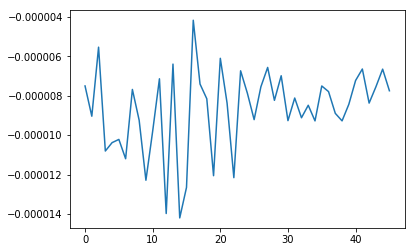

In [22]:
plt.plot(analyze.results['pull']['ti-block']['roi'])

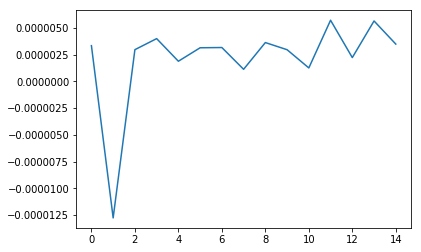

In [23]:
plt.plot(analyze.results['attach']['ti-block']['roi'])

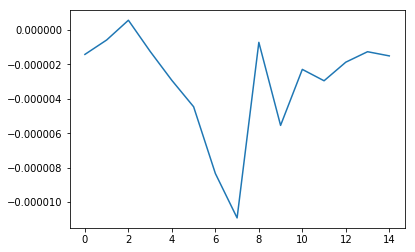

In [24]:
plt.plot(analyze.results['release']['ti-block']['roi'])

In [53]:
analyze = fe_calc()
analyze.prmtop = 'vac.topo'
analyze.trajectory = 'traj.001'
analyze.path = os.path.join('/home', 'dslochower', 'kirkwood', 'projects', 'smirnoff-host-guest-simulations', 
                            'systems', 'a-bam-p', 'original-2')


analyze.restraint_list = guest_restraints + conformational_restraints
analyze.collect_data()
analyze.methods = ['ti-block']

analyze.compute_largest_neighbor = False
analyze.ti_matrix = 'endpoints'
analyze.compute_roi = True

analyze.quicker_ti_matrix = True
analyze.bootcycles = 10000
analyze.compute_free_energy()
analyze.compute_ref_state_work([guest_restraints[0], guest_restraints[1], None, None, guest_restraints[2], None])

2018-06-07 02:02:15 PM Replacing /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/a014 with /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/p000 in ['/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/a000', '/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/a001', '/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/a002', '/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/a003', '/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/a004', '/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/a005', '/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/a006', '/home/dslochower/kirkwood/projects/smirnoff-h

2018-06-07 02:02:18 PM Load trajectories from /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/p009...
2018-06-07 02:02:18 PM Loaded 2500 frames...
2018-06-07 02:02:18 PM Load trajectories from /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/p010...
2018-06-07 02:02:18 PM Loaded 2500 frames...
2018-06-07 02:02:18 PM Load trajectories from /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/p011...
2018-06-07 02:02:18 PM Loaded 2500 frames...
2018-06-07 02:02:18 PM Load trajectories from /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/p012...
2018-06-07 02:02:18 PM Loaded 2500 frames...
2018-06-07 02:02:18 PM Load trajectories from /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/p013...
2018-06-07 02:02:18 PM Loaded 2500 frames...
2018-06-07 02:02:18 PM Load traject

2018-06-07 02:02:19 PM Loaded 2500 frames...
2018-06-07 02:02:19 PM Load trajectories from /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/r008...
2018-06-07 02:02:19 PM Loaded 2500 frames...
2018-06-07 02:02:20 PM Load trajectories from /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/r007...
2018-06-07 02:02:20 PM Loaded 2500 frames...
2018-06-07 02:02:20 PM Load trajectories from /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/r006...
2018-06-07 02:02:20 PM Loaded 2500 frames...
2018-06-07 02:02:20 PM Load trajectories from /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/r005...
2018-06-07 02:02:20 PM Loaded 2500 frames...
2018-06-07 02:02:20 PM Load trajectories from /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/r004...
2018-06-07 02:02:20 PM Loaded 2500 

In [54]:
print(f"{'Attach': <10} {analyze.results['attach']['ti-block']['fe']:+04.2f} +/- {analyze.results['attach']['ti-block']['sem']:2.2f}")
print(f"{'Pull': <10} {analyze.results['pull']['ti-block']['fe']:+04.2f} +/- {analyze.results['pull']['ti-block']['sem']:2.2f}")
print(f"{'Release': <10} {analyze.results['release']['ti-block']['fe']:+04.2f} +/- {analyze.results['release']['ti-block']['sem']:2.2f}")
print(f"{'Reference': <10} {analyze.results['ref_state_work']:+04.2f}")

fe = analyze.results['attach']['ti-block']['fe'] + analyze.results['pull']['ti-block']['fe'] + -1 * analyze.results['release']['ti-block']['fe'] + analyze.results['ref_state_work']
sem = np.sqrt( (analyze.results['attach']['ti-block']['sem']**2 + \
                analyze.results['pull']['ti-block']['sem']**2 + \
                analyze.results['release']['ti-block']['sem']**2
               )
             )
print(f"{'Total': <10} {fe:+2.2f} +/- {sem:2.2f}")

Attach     +9.82 +/- 0.08
Pull       +5.42 +/- 0.28
Release    +8.13 +/- 0.22
Reference  -7.14
Total      -0.04 +/- 0.37


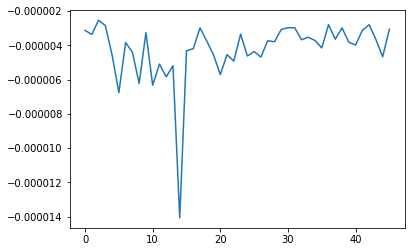

In [55]:
plt.plot(analyze.results['pull']['ti-block']['roi'])

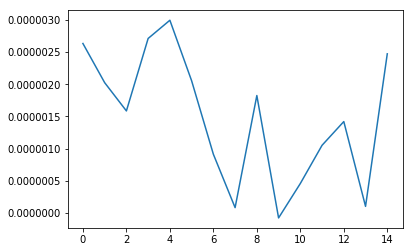

In [56]:
plt.plot(analyze.results['attach']['ti-block']['roi'])

In [57]:
prepared_data = analyze.prepare_data('attach')
analyze.run_ti('attach', prepared_data, 'ti-block')


2018-06-07 03:06:02 PM Running bootstrap calculations
2018-06-07 03:06:02 PM Working on fraction ... 1.0
2018-06-07 03:06:04 PM attach: computing ROI for ti-block


In [ ]:
# prepared_data = num_win, data_points, max_data_points, active_rest, force_constants, targets, ordered_values

prepared_data = 1, data_points, data_points, XXXX, [], [], [] 


In [58]:
prepared_data

(15,
 [2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500],
 2500,
 [array([ 0.  ,  0.02,  0.04, ...,  2.48,  3.74,  5.  ]),
  array([ 0.        ,  0.00012185,  0.00024369, ...,  0.01510902,
          0.02278538,  0.03046174]),
  array([ 0.        ,  0.00012185,  0.00024369, ...,  0.01510902,
          0.02278538,  0.03046174]),
  array([  0.00000000e+00,   7.31081807e-06,   1.46216361e-05, ...,
           9.06541441e-04,   1.36712298e-03,   1.82770452e-03]),
  array([  0.00000000e+00,   7.31081807e-06,   1.46216361e-05, ...,
           9.06541441e-04,   1.36712298e-03,   1.82770452e-03]),
  array([  0.00000000e+00,   7.31081807e-06,   1.46216361e-05, ...,
           9.06541441e-04,   1.36712298e-03,   1.82770452e-03]),
  array([  0.00000000e+00,   7.31081807e-06,   1.46216361e-05, ...,
           9.06541441e-04,   1.36712298e-03,   1.82770452e-03]),
  array([  0.00000000e+00,   7.31081807e-06,   1.46216361e-05, ...,
   

In [68]:
for number_trajectories in range(1, 200):

    trajectory_list = ['traj.{:03d}'.format(i) for i in range(1, number_trajectories + 1)]
    
    analyze = fe_calc()
    analyze.prmtop = 'vac.topo'
    analyze.trajectory = trajectory_list
    analyze.path = os.path.join('/home', 'dslochower', 'kirkwood', 'projects', 'smirnoff-host-guest-simulations', 
                                'systems', 'a-bam-p', 'original-2')


    analyze.restraint_list = guest_restraints + conformational_restraints
    analyze.collect_data()
    analyze.methods = ['ti-block']

    analyze.compute_largest_neighbor = False
    analyze.ti_matrix = 'endpoints'
    analyze.compute_roi = True

    analyze.quicker_ti_matrix = True
    analyze.bootcycles = 10000
    analyze.compute_free_energy()
    analyze.compute_ref_state_work([guest_restraints[0], guest_restraints[1], None, None, guest_restraints[2], None])

2018-06-07 03:35:26 PM Replacing /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/a014 with /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/p000 in ['/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/a000', '/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/a001', '/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/a002', '/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/a003', '/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/a004', '/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/a005', '/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/a006', '/home/dslochower/kirkwood/projects/smirnoff-h

2018-06-07 03:35:28 PM Loaded 2500 frames...
2018-06-07 03:35:28 PM Load trajectories from /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/a013...
2018-06-07 03:35:28 PM Received list of trajectories: ['/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/a013/traj.001']
2018-06-07 03:35:28 PM Loaded 2500 frames...
2018-06-07 03:35:29 PM Load trajectories from /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/p000...
2018-06-07 03:35:29 PM Received list of trajectories: ['/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/p000/traj.001']
2018-06-07 03:35:29 PM Loaded 2500 frames...
2018-06-07 03:35:29 PM Load trajectories from /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/p000...
2018-06-07 03:35:29 PM Received list of trajectories: ['/home/dslochower/kirkwood/project

2018-06-07 03:35:29 PM Loaded 2500 frames...
2018-06-07 03:35:29 PM Load trajectories from /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/p021...
2018-06-07 03:35:29 PM Received list of trajectories: ['/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/p021/traj.001']
2018-06-07 03:35:29 PM Loaded 2500 frames...
2018-06-07 03:35:29 PM Load trajectories from /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/p022...
2018-06-07 03:35:29 PM Received list of trajectories: ['/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/p022/traj.001']
2018-06-07 03:35:29 PM Loaded 2500 frames...
2018-06-07 03:35:29 PM Load trajectories from /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/p023...
2018-06-07 03:35:29 PM Received list of trajectories: ['/home/dslochower/kirkwood/project

2018-06-07 03:35:30 PM Loaded 2500 frames...
2018-06-07 03:35:30 PM Load trajectories from /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/p044...
2018-06-07 03:35:30 PM Received list of trajectories: ['/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/p044/traj.001']
2018-06-07 03:35:30 PM Loaded 2500 frames...
2018-06-07 03:35:30 PM Load trajectories from /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/p045...
2018-06-07 03:35:30 PM Received list of trajectories: ['/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/p045/traj.001']
2018-06-07 03:35:30 PM Loaded 2500 frames...
2018-06-07 03:35:30 PM Load trajectories from /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/r014...
2018-06-07 03:35:30 PM Received list of trajectories: ['/home/dslochower/kirkwood/project

2018-06-07 03:39:25 PM Replacing /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/r000 with /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/p045 in ['/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/r014', '/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/r013', '/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/r012', '/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/r011', '/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/r010', '/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/r009', '/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/r008', '/home/dslochower/kirkwood/projects/smirnoff-h

RuntimeError: can not find /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/original-2/a001/traj.002